## LGBM(Light GBM)

- XGB보다 훨씬 학습에 걸리는 시간과 메모리 사용량 적음
- 예측성능은 떨어지지 않으나 더 많은 기능을 제공함
- 유일한 **단점은 적은 데이터 세트에는 과적합을 일으킴**
- 다른 GBM계열 알고리즘과는 다르게 균형트리분할이 아닌 리프중심트리분할 사용
> **균형트리분할** : 최대한 균형잡힌 트리를 유지하면서 트리의 깊이를 최소화 하는 것 => 오버피팅에 강하지만 상대적으로 시간이 많이 필요함   
> 
> **리프중심트리분할** : 최대손실값을 가지는 리프노드를 지속적으로 분할 => 비대칭적인 트리구조를 가지지만 오류손실을 최소화할 수 있음
- GPU까지 지원이 됨

### 기본적인 튜닝 방안
- 1. num_leaves의 개수를 중심으로 한다
- 2. min_child_samples와 max_depth를 함께 조정한다
- 3. 모델복잡도를 줄인다

In [1]:
# lightgbm 버전확인
import lightgbm
print(lightgbm.__version__)

2.3.0


In [2]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(ftr, target, test_size=0.2, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정. 
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능. 
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
                 eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

C:\Users\82109\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict


[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355846
[7]	valid_0's binary_logloss: 0.330897
[8]	valid_0's binary_logloss: 0.306923
[9]	valid_0's binary_logloss: 0.28776
[10]	valid_0's binary_logloss: 0.26917
[11]	valid_0's binary_logloss: 0.250954
[12]	valid_0's binary_logloss: 0.23847
[13]	valid_0's binary_logloss: 0.225865
[14]	valid_0's binary_logloss: 0.215076
[15]	valid_0's binary_logloss: 0.205996
[16]	valid_0's binary_logloss: 0.196091
[17]	valid_0's binary_logloss: 0.186395
[18]	valid_0's binary_logloss: 0.17942
[19]	valid_0's binary_logloss: 0.174727
[20]	valid_0's binary_logloss: 0.168563
[21]	valid_0's binary_logloss: 0.165432
[22]	valid_0's binary_logloss: 0.160356
[23]	valid_0's binary_logloss: 0.155508
[24]	valid_0's binary_logloss: 

C:\Users\82109\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [4]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 2 75]]
정확도: 0.9474, 정밀도: 0.9494, 재현율: 0.9740,    F1: 0.9615, AUC:0.9926


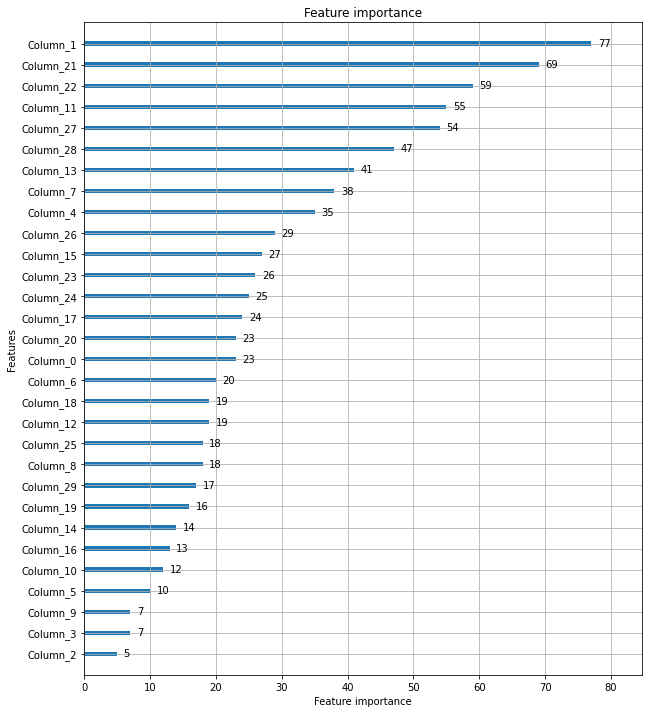

In [5]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)